In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import *
import seaborn as sns
import xgboost as xgb

import matplotlib.pyplot as plt
import joblib
from joblib import load
from sklearn.preprocessing import StandardScaler

In [224]:
df = pd.read_csv('xxx.csv', sep=";")
columns = ['class', 'dl_probabilities', 'surgery_class', 'oms', 'age']
df = df[columns]
df.dropna(axis=0)
df.head()

,class,dl_probabilities,surgery_class,oms,age
0,0,0.718501,1,0.0,74.80
1,0,0.951044,0,2.0,74.46
2,0,0.422944,0,2.0,74.15
3,1,0.062295,1,1.0,68.37
4,1,0.990110,1,1.0,73.28


In [225]:
combined_data = df.drop('class', axis=1)
labels = df['class']

X_np = np.array(combined_data)
sc = StandardScaler()
X_norm = sc.fit_transform(X_np)
X = X_norm

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.40, random_state=7)
print(f"Training set: {len(X_train)} patients")
print(f"Test set: {len(X_test)} patients")

Training set: 105 patients
Test set: 70 patients


In [227]:
models_params = {
    'LinearDiscriminant': {
        'model': LinearDiscriminantAnalysis(),
        'params': {
            'solver': ['svd', 'lsqr', 'eigen'], 
            'store_covariance' : [True, False], 
            'tol' : [1.0e-2, 1.0e-3, 1.0e-4]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear'], 
            'tol' : [1.0e-3, 1.0e-4], 
            'random_state' : [7], 
            'max_iter' : [100, 1000]
        }
    },
    'NeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'kd_tree']
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'criterion': ['gini', 'entropy'], 
            'max_features' : ['sqrt', None]
        }
    },
    'XGBClassifier': {
        'model': xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss'),
        'params': {
            'learning_rate': [0.01, 0.1],
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'min_child_weight': [1, 3],
            'subsample': [0.7, 0.9],
            'colsample_bytree': [0.7, 0.9]
        }
    }
}

In [228]:
best_models = {}
results = []

for model_name, mp in models_params.items():
    print(f"Optimisation des hyperparamètres pour {model_name}...")
    grid_search = GridSearchCV(mp["model"], mp["params"], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Meilleur modèle trouvé
    best_models[model_name] = grid_search.best_estimator_

    # Évaluation sur l'ensemble de test
    y_pred = best_models[model_name].predict(X_test)
    y_pred_proba = best_models[model_name].predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'Test Accuracy': accuracy,
    })

    print(f"{model_name} - Meilleurs hyperparamètres: {grid_search.best_params_}")
    print(f"{model_name} - Accuracy sur le test: {accuracy:.4f}")

best_model_name = max(best_models, key=lambda name: best_models[name].score(X_test, y_test))
print(f"Meilleur modèle global: {best_model_name}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)
print(results_df[['Model', 'Test Accuracy']])

Optimisation des hyperparamètres pour LinearDiscriminant...
LinearDiscriminant - Meilleurs hyperparamètres: {'solver': 'svd', 'store_covariance': True, 'tol': 0.01}
LinearDiscriminant - Accuracy sur le test: 0.8286
Optimisation des hyperparamètres pour LogisticRegression...
LogisticRegression - Meilleurs hyperparamètres: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'random_state': 7, 'solver': 'lbfgs', 'tol': 0.001}
LogisticRegression - Accuracy sur le test: 0.8286
Optimisation des hyperparamètres pour NeighborsClassifier...
NeighborsClassifier - Meilleurs hyperparamètres: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
NeighborsClassifier - Accuracy sur le test: 0.8714
Optimisation des hyperparamètres pour GaussianNB...
GaussianNB - Meilleurs hyperparamètres: {'var_smoothing': 1e-09}
GaussianNB - Accuracy sur le test: 0.8571
Optimisation des hyperparamètres pour DecisionTreeClassifier...
DecisionTreeClassifier - Meilleurs hyperparamètres: {'criterion': 'gini', 'max_depth'

In [229]:
model_filename = 'xxx.joblib'
joblib.dump(best_models[best_model_name], model_filename)

['clinical_data_best_model_20032025_2classes.joblib']

In [231]:
model_ = load('xxx.joblib')
print(model_)

KNeighborsClassifier(n_neighbors=7, weights='distance')


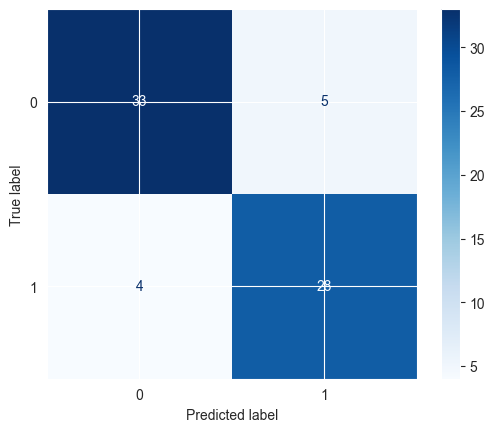

In [232]:
yhat_proba = model_.predict_proba(X_test)
yhat = np.argmax(yhat_proba, axis=1)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, yhat)

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [234]:
print(f'Accuracy score: {round(((33+28)/(33+5+4+28)),4)}')
print(f'Sensitivity score: {round((28/(28+4)),4)}')
print(f'Specificity score: {round((33/(33+5)), 4)}')

Accuracy score: 0.8714
Sensitivity score: 0.875
Specificity score: 0.8684


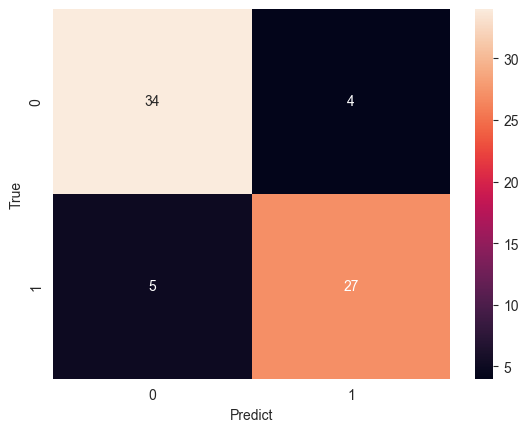

Accuracy score: 0.8714
Sensitivity score: 0.8438
Specificity score: 0.8947


In [242]:
### raining set:
yhat = model_.predict_proba(X_test)
conf_matrix_SGD_01 = confusion_matrix(y_test, np.where(yhat[:, 0] > 0.45, 0, 1))

ax_sgd_01 = sns.heatmap(conf_matrix_SGD_01, annot=True, fmt='d')
ax_sgd_01.set_title('')
ax_sgd_01.set_ylabel('True')
ax_sgd_01.set_xlabel('Predict')
plt.show()
print(f'Accuracy score: {round(((34+27) / (27+34+4+5)), 4)}')
print(f'Sensitivity score: {round((27 / (27+5)), 4)}')
print(f'Specificity score: {round((34 / (34 + 4)), 4)}')

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [13]:
combined_data

,surgery_class,oms,dl_probabilities_class0,dl_probabilities_class1,dl_probabilities_class2,age,class_gender
0,1,0.0,0.062260,0.783770,0.153970,74.80,0
1,0,2.0,0.044262,0.030447,0.925291,74.46,1
2,0,2.0,0.093085,0.105446,0.801468,74.15,0
3,1,1.0,0.662544,0.047270,0.290186,68.37,0
4,1,1.0,0.075252,0.006149,0.918599,73.28,1
...,...,...,...,...,...,...,...
169,2,1.0,0.153485,0.256297,0.590217,42.25,1
170,0,3.0,0.981317,0.000770,0.017913,73.28,0
171,0,2.0,0.696636,0.099962,0.203401,83.44,1
172,1,0.0,0.391521,0.135349,0.473130,70.35,0
